--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.25
Annualised Volatility: 0.24


Symbols      MMM   ABT  ABBV  ABMD  ACN  ATVI  ADBE   AMD   AAP   AES  ...  \
allocation  0.19  0.15  0.27  0.23  0.1  0.21  0.05  0.16  0.28  0.35  ...   

Symbols     WYNN   XEL   XRX  XLNX   XYL   YUM  ZBRA   ZBH  ZION   ZTS  
allocation  0.06  0.21  0.07  0.38  0.36  0.19  0.16  0.24  0.22  0.33  

[1 rows x 505 columns]
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.19


Symbols      MMM   ABT  ABBV  ABMD   ACN  ATVI  ADBE   AMD   AAP   AES  ...  \
allocation  0.27  0.16  0.08  0.28  0.23  0.35  0.26  0.23  0.07  0.24  ...   

Symbols     WYNN   XEL   XRX  XLNX   XYL   YUM  ZBRA   ZBH  ZION   ZTS  
allocation  0.35  0.17  0.23  0.35  0.17  0.23  0.38  0.21  0.35  0.18  

[1 rows x 505

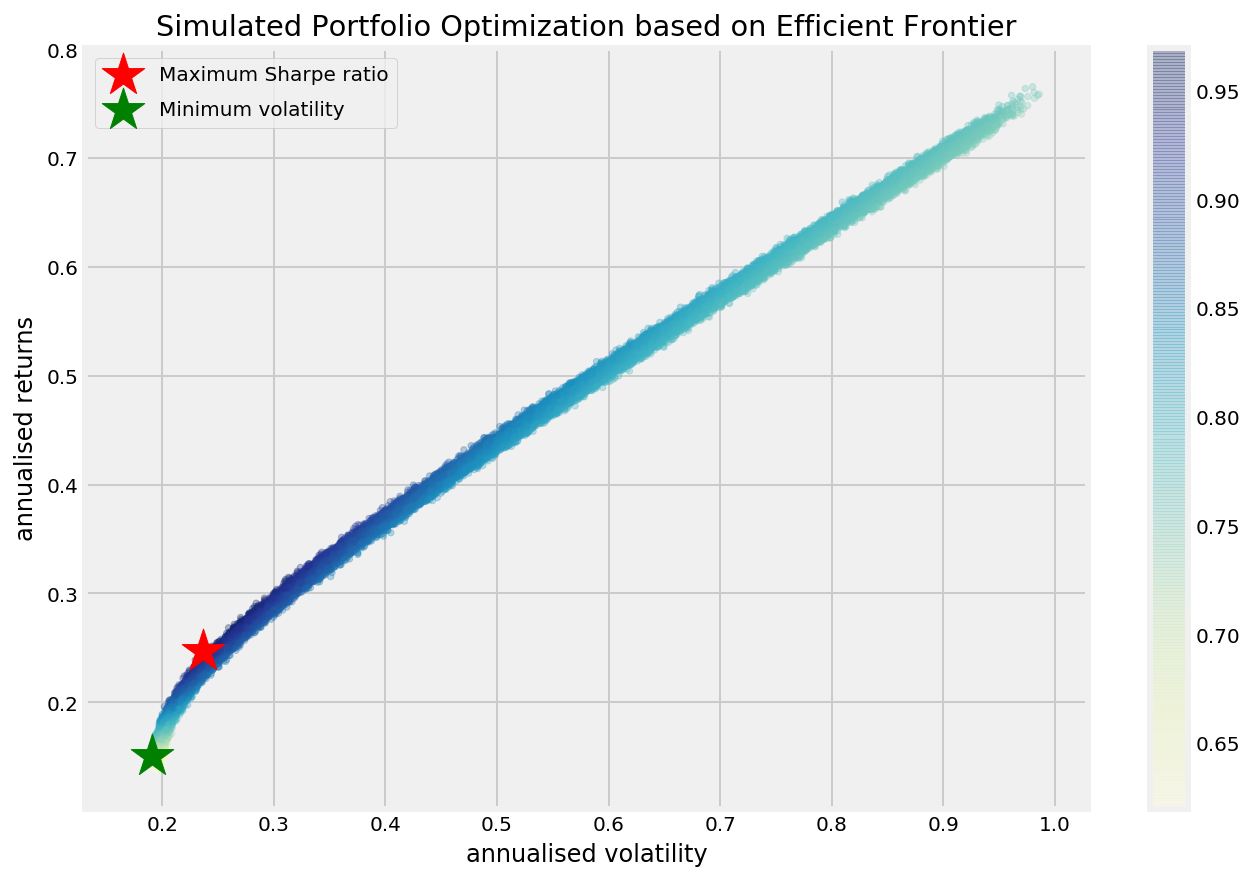

In [8]:
import bs4 as bs
import pickle
import requests
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

def save_sp500_tickers():
    resp = requests.get("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    soup = bs.BeautifulSoup(resp.text, "lxml")
    table = soup.find("table", {"class": "wikitable sortable"})
    tickers = []
    for row in table.findAll("tr")[1:]:
        ticker = row.findAll("td")[0].text
        tickers.append(ticker[:-1])

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers, f)

    return tickers

# DataFrame(save_sp500_tickers()).to_csv("SP500_Tickers.csv")

plt.style.use("fivethirtyeight")
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

stocks = pd.read_csv("SP500_Tickers.csv")
stocks = stocks.columns.tolist()
start_date = datetime.today() - timedelta(days = 3650)
end_date = datetime.today()
data = web.DataReader(stocks, "yahoo", start_date, end_date)["Close"]

returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=["allocation"])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=["allocation"])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    max_sharpe_allocation.to_csv("max_sharpe_allocation.csv")
    min_vol_allocation.to_csv("min_vol_allocation.csv")
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap="YlGnBu", marker="o", s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker="*",color="r",s=500, label="Maximum Sharpe ratio")
    plt.scatter(sdp_min,rp_min,marker="*",color="g",s=500, label="Minimum volatility")
    plt.title("Simulated Portfolio Optimization based on Efficient Frontier")
    plt.xlabel("annualised volatility")
    plt.ylabel("annualised returns")
    plt.legend(labelspacing=0.8)
    
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)